In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

#### Acquiring the dataset
Reference: https://qog.pol.gu.se/data/datadownloads/qogstandarddata

In [2]:
df = pd.read_csv("Datasets/qog_bas_cs_jan18.csv")
df = df[["cname","wdi_lifexp","wdi_popden", "bti_acp", "bti_pdi", "gle_cgdpc",
         "fh_pair", "al_ethnic", "al_language", "al_religion",
         "bti_aar", "vdem_gender", "bti_ci", "bti_foe","wdi_araland", "wdi_forest"]]

df = df.dropna()
df.head()

,cname,wdi_lifexp,wdi_popden,bti_acp,bti_pdi,gle_cgdpc,fh_pair,al_ethnic,al_language,al_religion,bti_aar,vdem_gender,bti_ci,bti_foe,wdi_araland,wdi_forest
0,Afghanistan,62.902683,50.176178,3.0,3.0,1282.6400,2,0.769345,0.614146,0.271684,4.0,0.530792,9.0,4.0,11.903011,2.067825
1,Albania,77.998390,105.441750,5.0,6.0,8516.7002,9,0.220426,0.039925,0.471852,8.0,0.828077,3.0,7.0,22.467154,28.191971
2,Algeria,75.635025,16.422152,5.0,3.0,5402.1699,7,0.339400,0.442662,0.009128,5.0,0.770516,7.0,6.0,3.136109,0.818057
4,Angola,60.806732,21.593380,2.0,3.0,3771.2000,3,0.786720,0.787019,0.627644,3.0,0.680371,4.0,4.0,3.930376,46.507420
6,Azerbaijan,71.724754,115.348816,2.0,2.0,9793.3096,6,0.204672,0.205392,0.489895,3.0,0.576483,4.0,3.0,23.305470,13.466484


#### Computing Pearson 's correlation coefficient between life expectancy and other values

In [3]:
life_expectancy = df['wdi_lifexp']
life_expectancy = life_expectancy.fillna(life_expectancy.mean())

def pearson_corr(first_column, second_column):
    second_column = second_column.fillna(second_column.mean())
    return np.cov(first_column, second_column)[1,0] / (np.std(first_column)*np.std(second_column))

data = [pearson_corr(life_expectancy, df[column]) for column in df.columns.values if column!='cname']
df_correlations = pd.DataFrame([data], columns = list(df.columns.values[1:]))
df_correlations.head()

,wdi_lifexp,wdi_popden,bti_acp,bti_pdi,gle_cgdpc,fh_pair,al_ethnic,al_language,al_religion,bti_aar,vdem_gender,bti_ci,bti_foe,wdi_araland,wdi_forest
0,1.008772,0.19213,0.423312,0.199336,0.50234,0.514225,-0.606459,-0.622697,-0.316992,0.15152,0.202752,-0.427087,0.154698,0.024731,0.088662


#### Attempting to predict life expectancy with population density and gdp per capita via Ordinary Least Squares

In [4]:
X = df[['wdi_popden', 'gle_cgdpc']]
X = sm.add_constant(X)
Y = df['wdi_lifexp']

model = sm.OLS(Y, X)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.235   
Dependent Variable: wdi_lifexp       AIC:                767.4884
Date:               2019-11-17 12:29 BIC:                775.7232
No. Observations:   115              Log-Likelihood:     -380.74 
Df Model:           2                F-statistic:        18.54   
Df Residuals:       112              Prob (F-statistic): 1.11e-07
R-squared:          0.249            Scale:              45.159  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const         66.5545    0.7710  86.3169  0.0000  65.0267  68.0822
wdi_popden     0.0003    0.0009   0.3367  0.7369  -0.0015   0.0021
gle_cgdpc      0.0003    0.0001   5.6280  0.0000   0.0002   0.0004
-----------------------------------------------------------------
Omnibus:              12.156       Durbin-Watson:          2.271 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       13.839
Skew:                 -0.843       Prob(JB):               0.001 
Kurtosis:             2.788        Condition No.:          19801 
=================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

<i>Analysis of the results here..
</i>

#### Predicted vs real plot

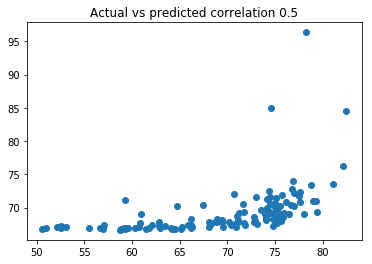

In [95]:
w0 = results.params.const
w1 = results.params.gle_cgdpc #Are these weights or X?
w2 = results.params.wdi_popden

actual = np.array(Y)
predicted = np.array(results.predict(X))
no_of_instances = len(Y)
no_of_parameters = 3 # both X and Y vars
_ = plt.scatter(actual, predicted)
_ = plt.title(f'Actual vs predicted correlation {round(np.corrcoef(actual, predicted)[1,0], 2)}')

#### Evaluation of results
<i>
Explanation of SSE, MSE, R2 AND MALLOW, what its good when to use and similar
</i>

In [108]:
sse = round(np.sum((real-predicted)**2), 2)
mse = round(np.mean((real-predicted)**2), 2)
r2 = 1 - np.sum((real - predicted)**2) / np.sum((real-np.mean(real))**2)
mallow = round(sse/mse - no_of_instances + 2 * no_of_parameters, 2)

print(f'SSE: {sse} | MSE: {mse} | R2: {r2} | MALLOW: {mallow}')

SSE: 5057.83 | MSE: 43.98 | R2: 0.24873618418560783 | MALLOW: 6.0


<i>Potential problems with OLS: 
    - Rank of a matrix needs to be 0
    - Endoigeneity
</i>

#### Heteroscedascity (Endoigeneity) check

<i>
Explanation of heteroscedascity here.
</i>

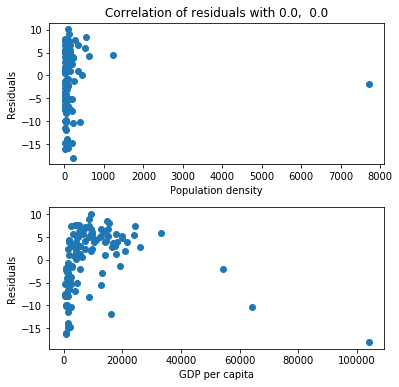

In [135]:
X = np.array(X)
Y = np.array(Y)
X1, X2 = X[:, 1], X[:, 2]

residuals = Y - predicted

fig, ax = plt.subplots(2,1, figsize=(6,6))
plt.subplots_adjust(hspace = 0.3)
ax[0].scatter(X1, residuals); ax[0].set_xlabel('Population density');
ax[1].scatter(X2, residuals); ax[1].set_xlabel('GDP per capita');
for i in range(0,2): ax[i].set_ylabel('Residuals')

_ = ax[0].set_title(f'Correlation of residuals with {round(np.corrcoef(X1, residuals)[1,0], 2)},  {round(np.corrcoef(X2, residuals)[1,0], 2)}')

Interaction variables

#### Checking for outcomes with polynomial regression 

#### Building different regression models to model life expectancy